# Analysis on the evolution of Indian Cuisine over time 

### Initializing for modelling

In [1]:
import numpy as np
from collections import defaultdict, OrderedDict
import random as rn
from copy import copy
import math
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (9,9)

Load dataset Recipes and Ingredients. They contain the following information:

__Recipe_Details__: Recipe ID,Title,Source,Cuisine,No. of Ingredients

__Recipe_Ingredients__: Recipe ID,Original Ingredient Name,Aliased Ingredient Name,Entity ID


In [2]:
recipe = open('Recipe_Details.txt')
ingredient = open('Recipe-Ingredients_Aliases.txt')
recipes_ = recipe.readlines()
# print(recipes_[0])
recipes_ = recipes_[1:]
ingredients_ = ingredient.readlines()
# print(ingredients_[0])
ingredients_ = ingredients_[1:]

In [3]:
Recipes = defaultdict(list)
Ingredients = set()
for each in ingredients_:
    line = each.strip().split(',')
    if line[-1]!='-':
        Ingredients.add(line[-1])
        Recipes[line[0]].append(line[-1])

print("Length of unique ingredients: ",len(Ingredients))

Length of unique ingredients:  724


Ingredients are not depicted by a continuous range of numbers. So, create a dictionary mapping the actual ingredient number with a continous number

In [4]:
ING_DICT = {}
for n,i in enumerate(Ingredients):
    ING_DICT[i] = n

Calculate the probabilities of recipes having ingredients more than, less than or equal to the average number of ingredients in a recipes

In [5]:
s = []
for each in Recipes:
    s.append(len(Recipes[each]))
avg = sum(s)/len(s)
print(avg,min(s),max(s))
less=0
more=0
same=0
for each in s:
    if each<avg:
        less+=1
    elif each in list(range(int(avg)-3,int(avg)+3)):
        same+=1
    else:
        more+=1
# print(len(s),list(range(int(avg)-3,int(avg)+3)),less,more,same)
prob = {}
prob['delete'] = (less/len(s))*100
prob['modify'] = (same/len(s))*100
prob['add'] = (more/len(s))*100
print(prob)

9.730297624282322 1 63
{'delete': 53.39711295651847, 'modify': 17.335452341168637, 'add': 29.2674347023129}


In [6]:
ingredients = list(range(len(Ingredients)))
print('length of recipes: ' + str(len(Recipes)) + ', length of unique ingredients' + str(len(ingredients)))

length of recipes: 159194, length of unique ingredients724


Define fitness functions for calculating fitness of each ingredient.
We assign fitness values in the following ways: <br>
-  random fitness values between 0,1 from a uniform distribution <br>
-  fitness values to ingredients based on how often they occur in the recipes dataset

In [7]:
def random_fitness():
    fitness={}
    for ing in ingredients:
        fitness[ing] = rn.uniform(0,1.0)
    return fitness
def frequency_weighted_fitness():
    fitness={}
    ings = defaultdict(int)
    for r in Recipes:
        for ing in Recipes[r]:            
            ings[ING_DICT[ing]]+= 1
    summ = sum(ings.values())
    for ing in ings:
        fitness[ing] = ings[ing]/summ
    return fitness

In [8]:
M = len(ingredients)/len(Recipes)

### Mathematical modelling

First choose random recipes and then make random ingredient list from it <br>
When we evolve our recipes over time, we maintain the ration of length of ingredients to length of recipes(M) constant 

Here, K is the average number of recipes, L is the number of ingredients we want
to modify/delete/add to one recipe in one iteration

In [9]:
K = int(avg) 
L = 4

The following are helper functions to 
- choose_ings_to_modify_with: choose which ingredients will replace the existing ones in the recipe
- add_new_I: add new ingredients to our new ingredients list to maintain the ratio of length of ingredients to length of recipes

In [10]:
def choose_ings_to_modify_with(I,L,recipe):
    temp_I_set = set(I)
    temp_I_set = temp_I_set.difference(set(recipe))
    modify_with = rn.sample(temp_I_set,L)
    return modify_with

def add_new_I(M,I,R,ingredients):
    temp_ing_set = set(ingredients)
    temp_ing_set = temp_ing_set.difference(set(I))
    more_i = int(M*len(R) - len(I))
    t = rn.sample(temp_ing_set,more_i)
    return t

## The Model

We slowly model a cuisine from the start

- First, we consider a random set of ingredients and create a set number (30) of receipes form them. <br>
- With each iteration, we pick a recipe, select L ingredients to modify and add these new recipes created to our recipes list.<br>
- The ingredients are modified if the fitness value of the ingredient to be replaced is less than the fitness value of the ingredient randomly selected to replace it.<br>
- There are two kinds of fitness functions we will experiment with: random fitness and frequency weithed fitness
- Then add new ingredients in ratio to the number of new recipes formed. <br>
- Continue this till there are no new recipes to add 

In [11]:
fit= []
fit.append(random_fitness())
fit.append(frequency_weighted_fitness())

In [12]:
ings_used_n_list = []
sorted_ings_used_n_list = []
RSN_list = [] 

for i in range(2):
    fitness = fit[i]
    
    ings_used_n = [] #all ingredients used
    sorted_ings_used_n = []
    number = 0
    RSN=[]

    for number in range(10):

        ans = []
        I0 = rn.sample(ingredients,30)
        len_R0 = int(len(I0)/M)
        R0 = defaultdict(list)
        for i in range(len_R0):
            R0[i] = rn.sample(I0,int(avg)) #avg = avg length of recipes

        R=R0
        I=I0
        ings_used_n.append(defaultdict(int))
        T = 0
        while(len(I)<len(ingredients)):

            temp_r = rn.sample(range(len(R)),1)[0]    

            to_modify_ings_indices_from_recipe = rn.sample(range(K),L)
            modify_with_direct_ingredients = choose_ings_to_modify_with(I,L,R[temp_r])

            new_r = R[temp_r].copy()
            num=0

            for x,y in zip(to_modify_ings_indices_from_recipe,modify_with_direct_ingredients):          
                if fitness[R[temp_r][x]]<fitness[y]:
                        new_r[x] = y
                num+=1
            R[len(R)]=new_r
            h = add_new_I(M,I,R,ingredients)
            if h !=[]:
                I.extend(h)
            T+= 1
        RSN.append(R)
        print(number,end=',')    
        
        for recipe in R:
            for ing in R[recipe]:
                ings_used_n[number][ing]+= 1
        sorted_ings_used_n.append(sorted(ings_used_n[number].values(),reverse=True)) #sorted list of ing frequencies
    
    ings_used_n_list.append(ings_used_n)
    sorted_ings_used_n_list.append(sorted_ings_used_n)
    RSN_list.append(RSN)


# print(max_ing[sorted(max_ing)[0]])

0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,

The following cuisine model brings a little more complexity in the modelling. Here, cuisines can be of different lengths. So, we can add/delete along with being able to modify ingredients in each iteration. This is done in accordance with the probabilities calculated at the start- probability of length greater than average occouring is the probability that ingredient is added, probabilities of lengths less than average occuring is probabiilty that ingredients can be deleted and probability that the length remains average +/-3 is probability that ingredient can be replaced.

In [13]:
ings_used_list = []
sorted_ings_used_list = []
RS_list = [] 

for i in range(2):
    fitness = fit[i]
    
    ings_used = [] #all ingredients used
    sorted_ings_used = []
    number = 0
    RS=[]

    for number in range(10):
        ans = []
        I0 = rn.sample(ingredients,30)
        len_R0 = int(len(I0)/M)
        R0 = defaultdict(list)
        for i in range(len_R0):
            R0[i] = rn.sample(I0,int(avg)) #avg = avg length of recipes

        R=R0
        I=I0
        ings_used.append(defaultdict(int))
        T = 0
        while(len(I)<len(ingredients)):

            temp_r = rn.sample(range(len(R)),1)[0]
            if R[temp_r]==[]:
                continue
            which = []
            if len(R[temp_r])>L:
                for e in range(L):
                    which.append(rn.randint(1,100))
                    l=L
            else:
                for e in range(len(R[temp_r])):
                    which.append(rn.randint(1,100))
                    l=len(R[temp_r])
            k=len(R[temp_r])

            to_modify_ings_indices_from_recipe = rn.sample(range(k),l)
            modify_with_direct_ingredients = choose_ings_to_modify_with(I,l,R[temp_r])

            new_r = R[temp_r].copy()
            num=0
            indices_to_delete=[]
            for x,y in zip(to_modify_ings_indices_from_recipe,modify_with_direct_ingredients):
                if which[num]<prob['delete']:#delete

                    indices_to_delete.append(x)
                elif which[num]<=prob['modify']+prob['delete']:#modify
                    if fitness[R[temp_r][x]]<fitness[y]:
                        new_r[x] = y
                elif which[num]<100:#add
                    new_r.append(y)
                num+=1
            indices_to_delete = sorted(indices_to_delete,reverse=True)
            for f in indices_to_delete:
                del new_r[f]
            R[len(R)]=new_r

            h = add_new_I(M,I,R,ingredients)
            if h !=[]:
                I.extend(h)

            T+= 1
        RS.append(R)
        print(number,end=',')

        for recipe in R:
            for ing in R[recipe]:
                ings_used[number][ing]+= 1
        sorted_ings_used.append(sorted(ings_used[number].values(),reverse=True))

    ings_used_list.append(ings_used)
    sorted_ings_used_list.append(sorted_ings_used)
    RS_list.append(RS)
    

# print(max_ing[sorted(max_ing)[0]])

0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,

Some ingredients are being left out. See if some are consistently left out

In [14]:
left = []
left.append(defaultdict(int))
left.append(defaultdict(int))

graph of left out ingredients in the random fitness plots.
ingredient index vs no. of times left out in 

0,1,2,3,4,5,6,7,8,9,

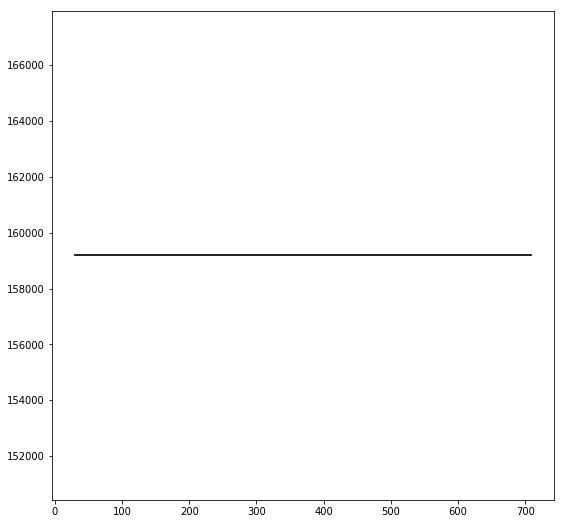

In [15]:
colors = ['r','b','g','c','m','y','k','#efefef','#555555','#242424']
for j in [0]:
    temp = set()
    for number,RS in enumerate(RS_list[j]):
        for R in RS:
            for ing in ingredients:
#                 print(ingredients)
                if ings_used_list[j][number][ing] == 0:
                    left[j][ing]+=1
        x = OrderedDict(left[j])
        plt.plot(x.keys(),x.values(),colors[number])
        print(number,end=',')

In [16]:
sorted(left[1]),sorted(left[0]),len(ingredients)

([],
 [30,
  34,
  70,
  236,
  249,
  261,
  289,
  316,
  335,
  362,
  394,
  397,
  415,
  423,
  429,
  461,
  473,
  521,
  538,
  545,
  551,
  609,
  690,
  703,
  709],
 724)

From the above we see that consistently the

To plot the ingrdient popularity curve across all

maxx is the value of the max number of ingredients used across 10 iterations. Then this value is normalised to plot frequency graph

In [17]:
maxx=[]
for t in sorted_ings_used:
    maxx.append(len(t))
maxx=max(maxx) #max length of ingredients
for each in sorted_ings_used_n_list[0]:
    for i in range(maxx-len(each)):
        each.append(0)

1. Plot the fitness values of the ingredients that have been left out
y = no. of times being left out
x = fitness values

2. Standard deviation of ingredient popularity along with mean.

This is to calculate the frequency graph

In [19]:
Length_recipes = []

In [29]:
length_recipes = []
for R in RS_list[1]:
    temp = []
    for num in R:
        temp.append(len(R[num]))
    length_recipes.append(temp)

In [30]:
#random_no_modifications_length_recipes
Length_recipes.append(length_recipes)

In [31]:
len(Length_recipes)

4

In [119]:
names = ['random fitness: constant length recipe','frequency weighted fitness: constant length','random fitness: variable length recipe','frequency weighted fitness: variable length']

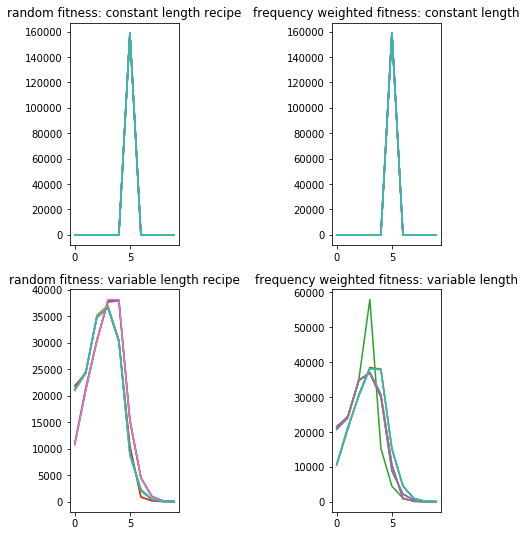

<Figure size 6000x6000 with 0 Axes>

In [121]:
fig, axs = plt.subplots(2, 4)
for i in range(4):
    n1,b,l=plt.hist(Length_recipes[i][0])
    n2,b,l=plt.hist(Length_recipes[i][1])
    n3,b,l=plt.hist(Length_recipes[i][2])
    n4,b,l=plt.hist(Length_recipes[i][3])
    n5,b,l=plt.hist(Length_recipes[i][4])
    n6,b,l=plt.hist(Length_recipes[i][5])
    n7,b,l=plt.hist(Length_recipes[i][6])
    n8,b,l=plt.hist(Length_recipes[i][7])
    n9,b,l=plt.hist(Length_recipes[i][8])
    n10,b,l=plt.hist(Length_recipes[i][9])
#     num=220+i+1
#     plt.subplot(num)
    if i==0:
        a=0
        b=0
    elif i==1:
        a=0
        b=2
    elif i==2:
        a=1
        b=0
    else:
        a=1
        b=2
        
    axs[a,b].plot(n10)
    axs[a,b].plot(n9)
    axs[a,b].plot(n8)
    axs[a,b].plot(n7)
    axs[a,b].plot(n6)
    axs[a,b].plot(n5)
    axs[a,b].plot(n4)
    axs[a,b].plot(n3)
    axs[a,b].plot(n2)
    axs[a,b].plot(n1)
    
    axs[a,b].set_title(names[i])
    
plt.xlabel('length of recipe')
plt.ylabel('number of recipes with said length')
plt.figure(num=None, figsize=(60, 60), dpi=100)
axs[0,1].set_visible(False)
axs[0,3].set_visible(False)
axs[1,1].set_visible(False)
axs[1,3].set_visible(False)
plt.show()

In [101]:
ING_USED_ALL = []

In [112]:
ING_USED = []
for ing in range(maxx):
    temp=0
    for i in range(10):
        temp += sorted_ings_used_n_list[1][i][ing]
    ING_USED.append(temp/10)

In [113]:
ING_USED_ALL.append(ING_USED)

In [114]:
len(ING_USED_ALL)

4

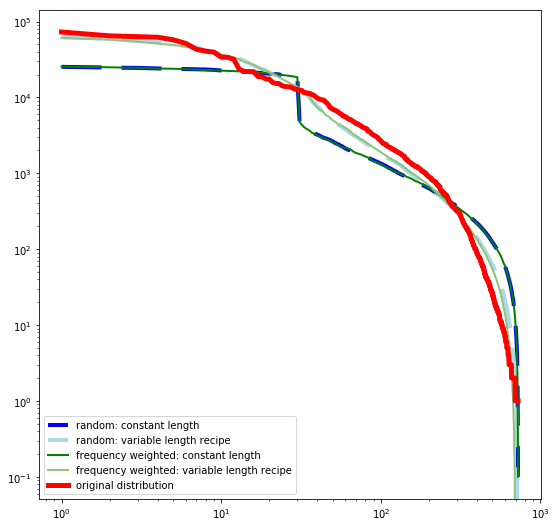

In [136]:
#original plot
frequency = defaultdict(int)
for each in Recipes:
    for ing in Recipes[each]:
        frequency[ing]+=1
y1 = sorted(frequency.values(),reverse=True)
x1 = range(1,len(y1)+1)

##CONSTANT RECIPE LENGTH
#RANDOM
y2 = ING_USED_ALL[0]
x2 = range(1,len(y2)+1)
#FREQUENCY WEIGHTED FITNESS
y3 = ING_USED_ALL[1]
x3 = range(1,len(y3)+1)

## VARIABLE RECIPE LENGTH
#RANDOM
y4 = ING_USED_ALL[2]
x4 = range(1,len(y4)+1)
# #FREQUENCY WEIGHTED FITNESS
y5 = ING_USED_ALL[3]
x5 = range(1,len(y5)+1)

plt.loglog(x2,y2,'-b', label='random: constant length',dashes=[10, 5, 10, 5],linewidth=4)
plt.loglog(x4,y4,'#ADD8E6', label='random: variable length recipe',dashes=[10, 5, 10, 5],linewidth=4)

plt.loglog(x3,y3,'-g', label='frequency weighted: constant length', linewidth=2)
plt.loglog(x5,y5,'#90C380', label='frequency weighted: variable length recipe',linewidth=2)

plt.loglog(x1,y1,'-r', label='original distribution',linewidth=5)
plt.legend(loc = 'lower left')
plt.xlabel('rank of ingredient')
plt.ylabel('number of recipes the ingredient occurs in')
plt.show()

### OBSERVATIONS

We see that a constant length of ingredient distribution is same regardless of it being randon or frequency weighted fitness values. 

The min and max recipe lengths was 0 and 60, however majority of the recipes had fewer ingredients, however there were some large values in the later half (about 27% ). Since we are modifying only 4 ingredients per recipe, and recipe chosen is random, recipe sizes couldn't grow on to values greater than 10.

### FUTURE WORK

In [ ]:
1. Work on region specific culinary evolution.
